## External Data

In [1]:
# Data Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option("max_colwidth", None)
# Machine Learning Libraries
from catboost import CatBoostClassifier
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
# Plot Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# cosmetic options
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg")
rc = {"figure.figsize": (6.4, 4.8),
      "figure.dpi": 300,
      "axes.titleweight": "bold",
      "axes.titlepad": 10,
      "axes.titlelocation": "left"}
sns.set_theme(context="notebook", style="darkgrid", color_codes=True, rc=rc)

In [2]:
def import_dataset(filename):
    """
    Import the dataset from the path.

    Parameters
    ----------
        filename : str
            filename with path

    Returns
    -------
        data : DataFrame

    Examples
    --------
        bank_mkt = import_dataset("../data/BankMarketing.csv")
    """
    bank_mkt = pd.read_csv(filename,
                           na_values=["unknown", "nonexistent"],
                           true_values=["yes", "success"],
                           false_values=["no", "failure"])
    # Treat pdays = 999 as missing values
    bank_mkt["pdays"] = bank_mkt["pdays"].replace(999, pd.NA)
    # `month` will be encoded to the corresponding number, e.g. "mar" -> 3
    month_map = {"mar": 3,
                 "apr": 4,
                 "may": 5,
                 "jun": 6,
                 "jul": 7,
                 "aug": 8,
                 "sep": 9,
                 "oct": 10,
                 "nov": 11,
                 "dec": 12}
    bank_mkt["month"] = bank_mkt["month"].replace(month_map)
    # `day_of_week` will be encoded to the corresponding number, e.g. "wed" -> 3
    dow_map = {"mon":1,
               "tue":2,
               "wed":3,
               "thu":4,
               "fri":5}
    bank_mkt["day_of_week"] = bank_mkt["day_of_week"].replace(dow_map)
    # Convert types, "Int64" is nullable integer data type in pandas
    bank_mkt = bank_mkt.astype(dtype={"age": "Int64",
                                      "job": "category",
                                      "marital": "category",
                                      "education": "category",
                                      "default": "boolean",
                                      "housing": "boolean",
                                      "loan": "boolean",
                                      "contact": "category",
                                      "month": "Int64",
                                      "day_of_week": "Int64",
                                      "duration": "Int64",
                                      "campaign": "Int64",
                                      "pdays": "Int64",
                                      "previous": "Int64",
                                      "poutcome": "boolean",
                                      "y": "boolean"})
    # Drop 12 duplicated rows
    bank_mkt = bank_mkt.drop_duplicates().reset_index(drop=True)
    # reorder ordinal categorical data
    bank_mkt["education"] = bank_mkt["education"].cat.reorder_categories(["illiterate", "basic.4y", "basic.6y", "basic.9y", "high.school", "professional.course", "university.degree"], ordered=True)
    return bank_mkt

In [3]:
bank_mkt = import_dataset("../data/BankMarketing.csv")

In [5]:
bank_mkt["year"]=2008
bank_mkt.loc[27682:, "year"] = 2009
bank_mkt.loc[39118:, "year"] = 2010
bank_mkt["date"] = pd.to_datetime(bank_mkt[["month", "year"]].assign(day=1))
# bank_mkt["date"] = pd.to_datetime(bank_mkt[["month", "year"]].assign(day=1)).dt.strftime("%y%m")

<AxesSubplot:xlabel='date'>

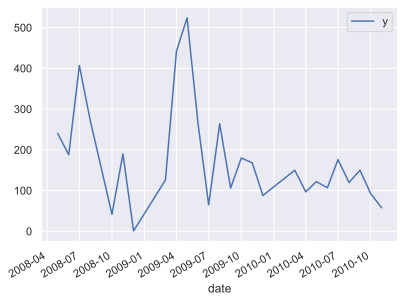

In [17]:
bank_mkt[["date", "y"]].groupby("date").sum().plot.line()

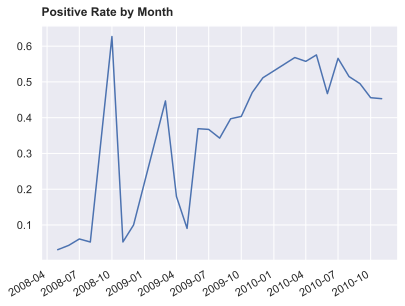

In [22]:
bank_mkt[["date", "y"]].groupby("date").mean().plot.line(xlabel="",
                                                         title="Positive Rate by Month",
                                                         legend=False);

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

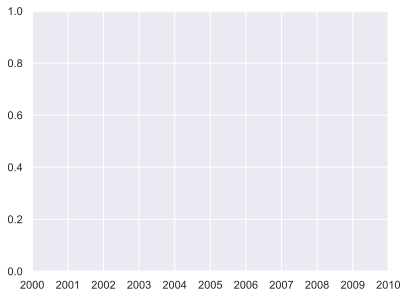

In [8]:
ax = sns.histplot(data=bank_mkt, x="date", y="y", stat="probability", hue="year")

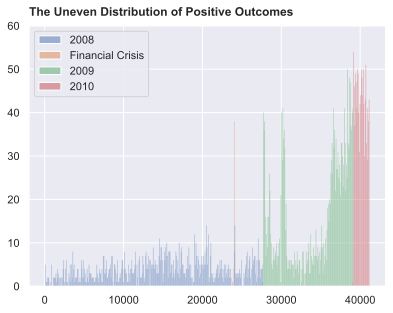

In [139]:
p = bank_mkt[bank_mkt.y == True].reset_index()
p.loc[(p.month == 10) & (p.year==2008), "year"] = "Financial Crisis"
ax = sns.histplot(data=p, x="index", stat="count", hue="year", bins=500, palette="deep", legend=True)
ax.get_legend().set_title("")
ax.set(title="The Uneven Distribution of Positive Outcomes", xlabel="", ylabel="");
ax.set_ylim(0,60);

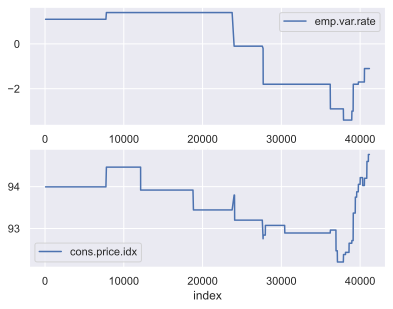

In [140]:
fig, axs = plt.subplots(2)
p.plot.line(x="index", y="emp.var.rate", ax=axs[0])
p.plot.line(x="index", y="cons.price.idx", ax=axs[1]);

## Models

In [4]:
def split_dataset(data, preprocessor, random_state=82):
    """
    Split dataset into train, test and validation sets using preprocessor.
    Because the random state of validation set is not specified, the validation set will be different each time when the function is called.

    Parameters
    ----------
        data : DataFrame

        preprocessor : Pipeline

    Returns
    -------
        datasets : tuple

    Examples
    --------
        from sklearn.preprocessing import OrdinalEncoder
        data = import_dataset("../data/BankMarketing.csv").interpolate(method="pad").loc[:, ["job", "education", "y"]]
        # To unpack all train, test, and validation sets 
        X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack train and test sets.
        X_train, y_train, X_test, y_test, *other_sets = split_dataset(data, OrdinalEncoder())
        # To unpack test and validation set
        *other_sets, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, OrdinalEncoder())
        # To unpack only train set.
        X_train, y_train, *other_sets = split_dataset(data, OneHotEncoder())
    """
    train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    for train_index, test_index in train_test_split.split(data.drop("y", axis=1), data["y"]):
        train_set = data.loc[train_index].sort_index()
        test_set = data.loc[test_index].sort_index()

    y_train = train_set["y"].astype("int").to_numpy()
    y_test = test_set["y"].astype("int").to_numpy()
    X_train = preprocessor.fit_transform(train_set, y_train)
    X_test = preprocessor.transform(test_set)
        
    train_validate_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    for ttrain_index, validate_index in train_validate_split.split(X_train, y_train):
        ttrain_set = train_set.loc[ttrain_index].sort_index()
        validate_set = train_set.loc[validate_index].sort_index()
    
    y_ttrain = ttrain_set["y"].astype("int").to_numpy()
    y_validate = validate_set["y"].astype("int").to_numpy()
    X_ttrain = preprocessor.fit_transform(ttrain_set, y_ttrain)
    X_validate = preprocessor.transform(validate_set)
    
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.to_numpy()
        X_test = X_test.to_numpy()
        X_ttrain = X_ttrain.to_numpy()
        X_validate = X_validate.to_numpy()

    return (X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate)

In [5]:
def benchmark(data, preprocessor, clf):
    """
    Benchmark preprocessor and clf's performance on train, validation and test sets. 
    All the data transformation should be handled by preprocessor and estimation should be handled by clf.
    
    Parameters
    ----------
        data : DataFrame
        
        preprocessor : Pipeline
        
        clf : estimator
        
        name : str, default = None
        
        compare_to: DataFrame, default = None
        
    """
    X_train, y_train, X_test, y_test, X_ttrain, y_ttrain, X_validate, y_validate = split_dataset(data, preprocessor)
    X_sets = [X_ttrain, X_validate, X_test]
    y_sets = [y_ttrain, y_validate, y_test]
    
    metric_names = ["TNR", "TPR", "bACC", "ROC", "REC", "PRE", "AP"]
    set_names = ["Train", "Validate", "Test"]
    metric_df = pd.DataFrame(index=metric_names, columns=set_names)
    
    try:
        clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
    except (ValueError, TypeError):
        clf.fit(X_ttrain, y_ttrain)
        
    for name, X, y in zip(set_names, X_sets, y_sets):
        # Re-fit model on train set before test set evaluation except CatBoost
        if name == "Test":
            try:
                clf.fit(X_ttrain, y_ttrain, eval_set=(X_validate, y_validate), verbose=False)
            except (ValueError, TypeError):
                clf.fit(X_train, y_train)
                
        y_pred = clf.predict(X)
        
        try:
            y_score = clf.decision_function(X)
        except AttributeError:
            y_score = clf.predict_proba(X)[:, 1]
            
        metrics = [recall_score(y, y_pred, pos_label=0),
                   recall_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   roc_auc_score(y, y_score),
                   recall_score(y, y_pred),
                   precision_score(y, y_pred),
                   average_precision_score(y, y_score)]
        metric_df[name] = metrics
        
    return metric_df

In [6]:
def cat_encode(X,
               drop=["duration", "y"],
               cut=None,
               cyclic=None,
               target=None,
               external=None):
    """
    Encode and transform categorical data into numerical values.
    
    Parameters
    ----------
        X : DataFrame
        
        drop : list, default = ["duration", "y"]
        
        cut : list
        
        cyclic : list
        
        target : list
        
        external : list
    
    Returns
    -------
        X : DataFrame

    Examples
    --------
    bank_mkt = import_dataset("../data/BankMarketing.csv")
    X = cat_encode(bank_mkt)
    """
    X = X.copy()
    
    if cut != None:
        if "pdays" in cut:
            X["pdays"] = X["pdays"].fillna(-1)
            # Clients who have been contacted but do not have pdays record
            X.loc[X["pdays"].isna() & X["poutcome"].notna(), "pdays"] = 999
            # Cut pdays into categories
            X["pdays"] = pd.cut(X["pdays"], [0, 3, 5, 10, 15, 30, 1000], labels=[3, 5, 10, 15, 30, 1000], include_lowest=True).astype("Int64")
    else:
        # Fill missing values in pdays as 999
        X["pdays"] = X["pdays"].fillna(999)
    
    if cyclic != None:
        if "month" in cyclic:
            X['month_sin'] = np.sin(2 * np.pi * X["month"]/12)
            X['month_cos'] = np.cos(2 * np.pi * X["month"]/12)
            X = X.drop("month", axis=1)
        if "day_of_week" in cyclic:
            X["day_of_week"] = X["day_of_week"].cat.codes
            X['day_sin'] = np.sin(2 * np.pi * X["day_of_week"]/5)
            X['day_cos'] = np.cos(2 * np.pi * X["day_of_week"]/5)
            X = X.drop("day_of_week", axis=1)
    
#     if external != None:
#         if "year" in external:
#             X["year"]=2008
#             X.loc[(27682<=X.index) | (X.index<39118), "year"] = 2009
#             X.loc[39118<=X.index, "year"] = 2010
#         elif "date" in external:
#             X["year"]=2008
#             X.loc[27682:39118, "year"] = 2009
#             X.loc[39118:, "year"] = 2010
#             X["date"] = pd.to_datetime(X[["month", "year"]].assign(day=1)).dt.strftime("%y%m").astype("int")
            
    # Transform target encoded feature as str
    if target != None:
        X[target] = X[target].astype("str")
        
    # Drop features
    X = X.drop(drop, axis=1)
    
    # Other categorical features will be coded as its order in pandas categorical index
    X = X.apply(lambda x: x.cat.codes if pd.api.types.is_categorical_dtype(x) else (x.astype("Int64") if pd.api.types.is_bool_dtype(x) else x))
    
    # Fill missing values as -1
    X = X.fillna(-1)
    
    return X

In [7]:
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, confusion_matrix

In [10]:
bank_mkt = import_dataset("../data/BankMarketing.csv")
X_08 = bank_mkt.loc[:27682].drop(["duration", "y"], axis=1)
X_09 = bank_mkt.loc[27682:39118].drop(["duration", "y"], axis=1).reset_index(drop=True)
X_10 = bank_mkt.loc[39118:].drop(["duration", "y"], axis=1).reset_index(drop=True)

In [11]:
y_08 = bank_mkt.loc[:27682, "y"]
y_09 = bank_mkt.loc[27682:39118, "y"].reset_index(drop=True)
y_10 = bank_mkt.loc[39118:, "y"].reset_index(drop=True)

In [248]:
y_08.value_counts()

False    26343
True      1340
Name: y, dtype: Int64

In [249]:
y_09.value_counts()

False    9209
True     2228
Name: y, dtype: Int64

In [250]:
y_10.value_counts()

True     1073
False     985
Name: y, dtype: Int64

In [12]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=62)
for train_index, test_index in train_test_split.split(X_08,y_08):
    X_train = X_08.loc[train_index]
    X_train = cat_encode(X_train, drop=[]).to_numpy()
    y_train = y_08.loc[train_index].to_numpy()
    X_test = X_08.loc[test_index]
    X_test = cat_encode(X_test, drop=[]).to_numpy()
    y_test = y_08.loc[test_index].to_numpy()

In [ ]:
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1,20])
cat_clf.fit(X_train, y_train, verbose=False)
y_score = cat_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_score), average_precision_score(y_test, y_score))

In [259]:
train_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=62)
for train_index, test_index in train_test_split.split(X_09,y_09):
    train_set = X_09.loc[train_index]
    test_set = y_09.loc[test_index]

In [260]:
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1,4])
cat_clf.fit(X_train, y_train, verbose=False)
y_score = cat_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_score), average_precision_score(y_test, y_score))

0.8023904778419494 0.472870256368066


In [244]:
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1,8])
cat_clf.fit(X_train, y_train, verbose=False)
y_score = cat_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_score), average_precision_score(y_test, y_score))

0.8037113614272502 0.47413352459621516


In [179]:
cat_clf.fit(X_train, y_train, verbose=False)

KeyError: 27682

In [178]:
X.date.value_counts()

805     7762
807     6681
905     5793
808     5173
806     4374
811     3615
904     2457
908      770
906      715
910      446
911      357
1007     311
1009     303
903      282
909      267
1003     264
1008     233
1006     229
1005     212
1010     204
907      177
1004     174
912      172
1011     128
810       67
812       10
Name: date, dtype: int64

In [162]:
drop_features = ["marital",
                 "education",
                 "default",
                 "housing",
                 "loan",
                 "duration",
                 "y"]

target_features = ["age", "job", "pdays", "poutcome", "year", "date"] 


year_encoder = FunctionTransformer(cat_encode, kw_args= {"drop": drop_features,
                                                         "target": target_features,
                                                         "external":["date"]})

target_encoder = make_pipeline(year_encoder, TargetEncoder(cols=target_features))

In [163]:
cat_clf = CatBoostClassifier(eval_metric="AUC", class_weights=[1,8])
cat_year = benchmark(bank_mkt, target_encoder, cat_clf)
cat_year

KeyError: 27682